In [59]:
import os
import spacy
import torch
import logging
import llmParser
import pdfplumber
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from langdetect import detect
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [60]:
# Directrorios requeridos:
homePath = os.path.expanduser('~') # Ruta del directorio de inicio del usuario
dataPath = os.path.join(homePath, 'NLP_p2025', 'CVBestFit') # Ruta del directorio de trabajo
cvsPath = os.path.join(dataPath, 'cvs') # Ruta donde se almacenan los CVs sin procesar
jobDescriptionsPath = os.path.join(dataPath, 'jobDescriptions') # Ruta donde se almacenan los documentos descriptivos
jobDescriptionFile = os.path.join(jobDescriptionsPath, 'Especialista en Instrumentacion y control.pdf') # Directorio del documento descriptivo

In [61]:
# Fuciones de soporte:
def loadModels(useGpu=True):
    """ Carga el modelo de spaCy para español e inglés para GPU sí hay alguna disponible, caso contrario: carga modelos de CPU."""
    # Se verifica si Torch detecta la GPU:
    gpuAvailable = torch.cuda.is_available()

    if useGpu and gpuAvailable:
        try:
            spacy.require_gpu()  # Forzar SpaCy a usar GPU si está disponible
            modelEs = spacy.load("es_dep_news_trf")
            modelEn = spacy.load("en_core_web_trf")

            print(f"✅ GPU Disponible para spaCy: {torch.cuda.get_device_name(0)} 🖥️")

        except Exception as e:
            print("⚠️  Error al cargar modelos con GPU. Se cargaron modelos del CPU.")
            print("Detalles del error:", str(e))
            modelEs = spacy.load("es_core_news_md")
            modelEn = spacy.load("en_core_web_md")

    else:
        print("❌ No GPU activada o disponible para spaCy. Se utilizará CPU.")
        modelEs = spacy.load("es_core_news_md")
        modelEn = spacy.load("en_core_web_md")

    return modelEs, modelEn

def chooseModel(text):
    """ Detecta el idioma del texto y devuelve el modelo spaCy correspondiente ('es' o 'en')."""
    language = detect(text)

    if language == "es":
        model = modelEs # Seleccionar modelo en español
    elif language == "en":
        model = modelEn # Seleccionar modelo en ingles
    else:
        raise Exception(f"Idioma no soportado: {language}")
    
    return model

def extractText(docPath):
    """ Extrae y concatena el texto de todas las páginas de un archivo PDF."""
    with pdfplumber.open(docPath) as pdf:
        return "\n".join([page.extract_text() or '' for page in pdf.pages])
    
def extractCVsInfo(cvPath):
    """ Extrae la información de los CVs en un directorio dado y la almacena en un diccionario formateado."""

    ######################## Suprimir avisos de pdfplumber sobre cropbox ############################
    logging.getLogger("pdfminer").setLevel(logging.ERROR)
    logging.getLogger("pdfplumber").setLevel(logging.ERROR)

    parser = llmParser.LLMParser() # Cargar modelo de lenguaje para parsear la información de los CVs
    cvDict = {} #Diccionario con la información de los CVs:

    for i, file in enumerate(os.listdir(cvPath)):
        if file.endswith('.pdf'):
            cPath = os.path.join(cvPath, file)
            text = extractText(cPath) # Extraer el texto del documento actual
            cvInfo = parser.extract_CVInfo(text) # Extrae la información solicitada en formato JSON
            
        cvDict[i] = cvInfo # Almacenar la información del CV en el diccionario
        print(f"Procesado: {cPath}")

    return cvDict

def extractJobDescriptionInfo(jobDescriptionFile):
    """ Extrae la información de los CVs en un directorio dado y la almacena en un diccionario formateado."""

    ######################## Suprimir avisos de pdfplumber sobre cropbox ############################
    logging.getLogger("pdfminer").setLevel(logging.ERROR)
    logging.getLogger("pdfplumber").setLevel(logging.ERROR)

    parser = llmParser.LLMParser() # Cargar modelo de lenguaje para parsear y castear la información de los CVs
    jobDescriptionText = extractText(jobDescriptionFile) # Extraer el texto del documento actual
    jobDescriptionInfo = parser.extract_jobDescriptionInfo(jobDescriptionText) # Extrae la información solicitada en formato JSON

    return jobDescriptionInfo
    
def normalizeText(text):
    """ Normaliza el texto eliminando stopwords y signos de puntuación, y devuelve los lemas en minúsculas """
    model = chooseModel(text) # Seleccionar el modelo en base al idioma
    doc = model(text) # Tokenización y POS Tagging

    # Convertir a minúsculas, remover stop-words y signos de puntuación
    lemmas = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(lemmas)

def radarSkills(scoresPerSkill, jobInfo, candidatos=None, mode="individual"):
    """
    Visualiza habilidades en gráficos de radar según el modo seleccionado.

    Parámetros:
    - scoresPerSkill: dict con las similitudes normalizadas (0 a 10) por habilidad para cada candidato.
    - jobInfo: objeto con atributos hardSkills y softSkills.
    - candidatos: lista opcional de candidatos a comparar (solo para modo 'compare').
    - modo: 'individual', 'hard', 'soft', 'compare'.
    """

    if mode not in ["individual", "hard", "soft", "compare"]:
        raise ValueError("Modo inválido. Usa: 'individual', 'hard', 'soft', o 'compare'.")

    hardSkills = jobInfo.hardSkills
    softSkills = jobInfo.softSkills

    if mode == "individual":
        for candidato, skills in scoresPerSkill.items():
            fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(polar=True))
            fig.suptitle(f"Habilidades de {candidato}", fontsize=16)

            # Técnicas
            values = [skills.get(skill, 0) for skill in hardSkills]
            values += values[:1]
            angles = np.linspace(0, 2 * np.pi, len(hardSkills), endpoint=False).tolist()
            angles += angles[:1]
            axs[0].plot(angles, values, linewidth=2)
            axs[0].fill(angles, values, alpha=0.25)
            axs[0].set_xticks(angles[:-1])
            axs[0].set_xticklabels(hardSkills, fontsize=9)
            axs[0].set_title("Técnicas", pad=15)

            # Blandas
            values = [skills.get(skill, 0) for skill in softSkills]
            values += values[:1]
            angles = np.linspace(0, 2 * np.pi, len(softSkills), endpoint=False).tolist()
            angles += angles[:1]
            axs[1].plot(angles, values, linewidth=2)
            axs[1].fill(angles, values, alpha=0.25)
            axs[1].set_xticks(angles[:-1])
            axs[1].set_xticklabels(softSkills, fontsize=9)
            axs[1].set_title("Blandas", pad=15)

            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()

    elif mode == "hard":
        for candidato, skills in scoresPerSkill.items():
            values = [skills.get(skill, 0) for skill in hardSkills]
            values += values[:1]
            angles = np.linspace(0, 2 * np.pi, len(hardSkills), endpoint=False).tolist()
            angles += angles[:1]

            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
            ax.plot(angles, values, linewidth=2)
            ax.fill(angles, values, alpha=0.25)
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(hardSkills, fontsize=9)
            ax.set_title(f"{candidato} - Habilidades Técnicas", pad=20)
            plt.tight_layout()
            plt.show()

    elif mode == "soft":
        for candidato, skills in scoresPerSkill.items():
            values = [skills.get(skill, 0) for skill in softSkills]
            values += values[:1]
            angles = np.linspace(0, 2 * np.pi, len(softSkills), endpoint=False).tolist()
            angles += angles[:1]

            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
            ax.plot(angles, values, linewidth=2)
            ax.fill(angles, values, alpha=0.25)
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(softSkills, fontsize=9)
            ax.set_title(f"{candidato} - Habilidades Blandas", pad=20)
            plt.tight_layout()
            plt.show()

    elif mode == "compare":
        if not candidatos or len(candidatos) < 2:
            raise ValueError("Para 'compare', proporciona una lista de al menos dos candidatos.")

        allSkills = hardSkills + softSkills
        angles = np.linspace(0, 2 * np.pi, len(allSkills), endpoint=False).tolist()
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=(14, 7), subplot_kw=dict(polar=True))
        ax.set_title("Comparación de Habilidades", pad=20)

        for cand in candidatos:
            if cand not in scoresPerSkill:
                continue
            skills = scoresPerSkill[cand]
            values = [skills.get(skill, 0) for skill in allSkills]
            values += values[:1]
            ax.plot(angles, values, linewidth=2, label=cand)
            ax.fill(angles, values, alpha=0.1)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(allSkills, fontsize=9)
        ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
        plt.tight_layout()
        plt.show()

### Funciones para evaluar el perfil general del candidato contra la vacante:

In [62]:
# Se define la función de vectorización del corpus:
def tfIdfWeightedEmbedding(texts, modelW2V):
    """Vectoriza el corpus de textos usando TF-IDF y calcula los embeddings ponderados de cada documento."""
    if isinstance(texts, str):  # Si es solo una frase, la convertimos a lista
        texts = [texts]
    
    # Se vectorizan con TF-IDF los textos (documentos)
    vectorizerTfIdf = TfidfVectorizer()
    tfIdfVectors = vectorizerTfIdf.fit_transform(texts)
    uniqueWords = vectorizerTfIdf.get_feature_names_out()

    # Se mapean los pesos TF-IDF:
    tfIdfWeights = []
    for doc in tfIdfVectors:
        wordWeight = {uniqueWords[i]: doc[0, i] for i in doc.nonzero()[1]}
        tfIdfWeights.append(wordWeight)

    # Se calculan los embeddings ponderados de cada documento:
    embedings = {}

    for i, doc in enumerate(texts):
        weights = [] # Pesos TF-IDF
        vectors = [] # Vectores ponderados de las palabras encontradas
        tokens = doc.split() # Documentos tokenizados

        for word in tokens:
            if word in modelW2V.wv and word in tfIdfWeights[i]:
                vectors.append(modelW2V.wv[word] * tfIdfWeights[i][word]) # Se guarda el vector ponderado
                weights.append(tfIdfWeights[i][word]) # Se guarda el peso TF-IDF de la palabra

        if vectors: # Sí hay palabras con word embeddings y TF-IDF:
            embedings[i] = np.sum(vectors, axis=0) / sum(weights) # Calcular el promedio ponderado de los vectores
        else: # Sí no:
            embedings[i] = np.zeros(modelW2V.vector_size) # Regresar un vector de ceros para ese documento

    return embedings

### Funciones para evaluar las habilidades de los candidatos contra la vacante

In [63]:
# Se definen las funciones para calcular el score heurístico de similitud entre habilidades:
def evaluateSkill(modelST, jobSkills, cvSkills, weight, mandatorySkill=False, threshold=0.3):
    """ Evalúa la similitud entre las habilidades de un CV y las habilidades requeridas para un puesto de trabajo."""	
    score = 0
    totalScore = 0

    skillDict = {} # Diccionario para almacenar las habilidades laborales y sus scores por candidato

    for jobSkill in jobSkills:
        jobSkillVec = modelST.encode(jobSkill) # Extraer el vector de la habilidad usando el modelo SentenceTransformer
        maxSim = 0

        for cvSkill in cvSkills:
            cvSkillVec = modelST.encode(cvSkill) # Extraer el vector de la habilidad usando el modelo SentenceTransformer
            # Calcular la similitud coseno entre los vectores de las habilidades
            cosSim = cosine_similarity([jobSkillVec], [cvSkillVec]).item()

            maxSim = max(cosSim, maxSim) # Guardar la máxima similitud entre las habilidades

            #print(f"Similitud entre '{jobSkill}' y '{cvSkill}': {cosSim:.2f}") # Mostrar la similitud entre las habilidades

        totalScore += weight

        if mandatorySkill: # Si la habilidad es obligatoria:
            score = weight if cosSim >= threshold else -weight # Penalizar si no cumple el umbral

        else: # Si la habilidad no es obligatoria:
            score = weight if cosSim >= threshold else 0 # No penalizar si no cumple el umbral

        skillDict[jobSkill] = maxSim # Guardar el score de la habilidad en el diccionario
        

    return score, totalScore, skillDict # Regresar el score heurístico y el total de puntos posibles


def heuristicSkillScore(jobInfo, cvDict, modelST):
    """Calcula el score de similitud y retorna un diccionario con los scores individuales por habilidad requerida."""

    weights = {
        "hardSkills": 5,
        "softSkills": 3,
        "mandatoryHardSkills": 10,
        "mandatorySoftSkills": 6
    }

    categories = [
        (modelST, jobInfo.hardSkills, cvDict.hardSkills, weights["hardSkills"]),
        (modelST, jobInfo.softSkills, cvDict.softSkills, weights["softSkills"]),
    ]

    score = 0
    totaPossibleScore = 0
    mergedSkillDict = {}  # Para juntar todos los resultados

    for cat in categories:
        # Soportar tanto con como sin `mandatorySkill`
        if len(cat) == 4:
            modelST, jobSkills, cvSkills, weight = cat
            mandatory = False
        else:
            modelST, jobSkills, cvSkills, weight, mandatory = cat

        if cvSkills:
            subScore, subTotal, skillDict = evaluateSkill(modelST, jobSkills, cvSkills, weight, mandatory)
            score += subScore
            totaPossibleScore += subTotal
            mergedSkillDict.update(skillDict)  # Combinar diccionarios
        else:
            continue

    heuristicScore = max(score, 0) / totaPossibleScore if totaPossibleScore else 0

    return heuristicScore, mergedSkillDict


# def heuristicSkillScore(jobInfo, cvDict, modelST):
#     """ Calcula el score de similitud entre las habilidades de un CV y las habilidades requeridas para un puesto de trabajo."""	
#     weights = {
#         "hardSkills": 5, # Peso de las habilidades técnicas
#         "softSkills": 3, # Peso de las habilidades blandas
#         "mandatoryHardSkills": 10, # Peso de las habilidades técnicas obligatorias
#         "mandatorySoftSkills": 6 # Peso de las habilidades blandas obligatorias
#     }

#     categories = [
#         (modelST, jobInfo.hardSkills, cvDict.hardSkills, weights["hardSkills"]),
#         (modelST, jobInfo.softSkills, cvDict.softSkills, weights["softSkills"]),
#     ]

#     score = 0
#     totaPossibleScore = 0

#     for modelST, jobSkills, cvSkills, weight in categories:
#         if cvSkills:
#             subScore, subTotal, skillDict = evaluateSkill(modelST, jobSkills, cvSkills, weight)
#             score += subScore
#             totaPossibleScore += subTotal
#         else:
#             continue

#     heuristicScore = max(score, 0) / totaPossibleScore if totaPossibleScore else 0

#     return heuristicScore, skillDict # Regresar el score heurístico y el total de puntos posibles

In [64]:
# Se extrae la información de los CVs y el puesto de trabajo:
cvsInfo = extractCVsInfo(cvsPath) # Extraer la información de los CVs
jobInfo = extractJobDescriptionInfo(jobDescriptionFile) # Extraer la información de la vacante

Procesado: C:\Users\Estiven Angel\NLP_p2025\CVBestFit\cvs\CurriculumProfesionalSinFotoSencilloBlancoyNegro.pdf
Procesado: C:\Users\Estiven Angel\NLP_p2025\CVBestFit\cvs\CurriculumVitae.pdf
Procesado: C:\Users\Estiven Angel\NLP_p2025\CVBestFit\cvs\CV-CarolFruto.pdf
Procesado: C:\Users\Estiven Angel\NLP_p2025\CVBestFit\cvs\CVHipolitoRodriguez.pdf
Procesado: C:\Users\Estiven Angel\NLP_p2025\CVBestFit\cvs\CVkirvincaballero.G.pdf
Procesado: C:\Users\Estiven Angel\NLP_p2025\CVBestFit\cvs\CVP-AbdielJimenez.pdf
Procesado: C:\Users\Estiven Angel\NLP_p2025\CVBestFit\cvs\CV_Emanuel_Valdes_.pdf
Procesado: C:\Users\Estiven Angel\NLP_p2025\CVBestFit\cvs\CV_Emanuel_Valdes_.pdf
Procesado: C:\Users\Estiven Angel\NLP_p2025\CVBestFit\cvs\Estiven CV updated Dec 2023.pdf
Procesado: C:\Users\Estiven Angel\NLP_p2025\CVBestFit\cvs\HARLLYNVELAZCO-CURRICULUM.pdf
Procesado: C:\Users\Estiven Angel\NLP_p2025\CVBestFit\cvs\JuanRemiceResume-1.pdf
Procesado: C:\Users\Estiven Angel\NLP_p2025\CVBestFit\cvs\MiguelGQcv.p

In [65]:
# Cargar modelos necesarios para el procesamiento de texto:
modelEs, modelEn = loadModels() # Cargar los modelos para español e inglés
modelST = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2') # Cargar el modelo de SentenceTransformer
modelW2V = Word2Vec.load(r"./modelW2V/modelW2V.model")# Se carga el modelo word2vec entrenado

# Se almacenan los textos de los CVs:
rawTexts = [] # Texto de los CVs de la vacante actual

for i in range(len(cvsInfo)):
    cvText = cvsInfo[i].profile # Extraer el peril del CV del candidato
    rawTexts.append(cvText) # Almacenar el texto del CV

# Extraer la descripción y responsabilidades del puesto trabajo
jobDescription = jobInfo.description + " ".join(jobInfo.responsibilities) # Extraer la descripción y responsabilidades del puesto de trabajo

# Se almacenan el texto de la vacante:
rawTexts.append(jobDescription)

# Extraer TF-IDF embeddings ponderados de los CVs y descripciones de la vacante actual:
lowerRawTexts = [text.lower() for text in rawTexts] # Convertir a minúsculas
embeddings = tfIdfWeightedEmbedding(lowerRawTexts, modelW2V) # Extraer TF-IDF embeddings

✅ GPU Disponible para spaCy: NVIDIA GeForce RTX 3050 Laptop GPU 🖥️


In [66]:
jobDescriptionVec = embeddings[len(embeddings)-1]  # El último vector ponderado corresponde a la descripción de la vacante

scores = {} # Se almacenan los scores (similitud coseno) de cada CV
heuristicScores = {} # Se almacenan los scores heurísticos de cada CV
scoresPerSkill = {}

for i, file in enumerate(os.listdir(cvsPath)):
    if file.endswith('.pdf'):
        cosSim = cosine_similarity([jobDescriptionVec], [embeddings[i]]).item() # Calcular similitud del CV contra la descripción
        nameCV = cvsInfo[i].name
        nameCV = nameCV.title() # Convertir el nombre del CV a formato título

        scores[nameCV] = cosSim # Se guarda el score como valor y el nombre del CV como clave
        heuristicScores[nameCV], skillDict = heuristicSkillScore(jobInfo, cvsInfo[i], modelST) # Calcular el score heurístico

        scoresPerSkill[nameCV] = skillDict # Almacenar el score heurístico por habilidad

    ######################## Suprimir avisos de pdfplumber sobre cropbox ############################
    logging.getLogger("pdfminer").setLevel(logging.ERROR)

# Se ordenan los scores de manera descendente:
scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
heuristicScores = dict(sorted(heuristicScores.items(), key=lambda item: item[1], reverse=True))

combinedScores = {} # Se almacenan los scores combinados de cada CV

for candidate in scores:
    combinedScore = (0.8 * scores[candidate] + 0.2 * heuristicScores[candidate]) # Calcular el score combinado
    percentageScore = round(combinedScore * 100, 2) # Convertir a porcentaje
    combinedScores[candidate] = percentageScore # Almacenar el score combinado

combinedScores = dict(sorted(combinedScores.items(), key=lambda item: item[1], reverse=True)) # Ordenar los scores combinados de manera descendente

In [67]:
# Crear un DataFrame con la información de la descripción del puesto de trabajo:
jobData = {key: value for key, value in jobInfo.model_dump().items()}  # Utiliza dict() para convertir el modelo a diccionario
dfJobDesc = pd.DataFrame([jobData])  # Convertir a DataFrame
dfJobDesc.columns = ["Titulo", "Descripción", "Responsabilidades", "Habilidades Técnicas", "Habilidades Blandas", "Ubicación"]  # Renombrar columnas

display(dfJobDesc) # Mostrar el DataFrame

,Titulo,Descripción,Responsabilidades,Habilidades Técnicas,Habilidades Blandas,Ubicación
0,Mantenimiento y Control de Sistemas en Plantas,Responsable de la realización de trabajos de m...,[Realizar trabajos de mantenimiento y crear ba...,"[SAP Modulo de Mantenimiento, ELECTRONICA, OFF...","[Comunicación acertiva, autodidacta]",Panama


In [68]:
# Crear un DataFrame con la información de los CVs:
cvData = {key: value.model_dump() for key, value in cvsInfo.items()} # Convertir a diccionario
dfCVs = pd.DataFrame(cvData).T # Convertir a DataFrame
dfCVs.columns = ["Nombre", "Correo", "Teléfono", "Perfil", "Ubicación", "Experiencia", "Educación", "Habilidades Técnicas", "Habilidades Blandas"] # Renombrar columnas
dfCVs.set_index("Nombre", inplace=True) # Establecer la columna "name" como índice
dfCVs = dfCVs[~dfCVs.index.duplicated(keep='first')] # Eliminar duplicados

In [69]:
# Crear un DataFrame con los scores:
scoresDF = pd.DataFrame(list(scores.items()), columns=['Candidato', 'Puntuación']) # Crear un DataFrame
display(scoresDF) # Mostrar el DataFrame

,Candidato,Puntuación
0,Emanuel Valdés,0.981054
1,Manuel,0.970437
2,Kirvin Adriel González,0.969623
3,Miguel Gutiérrez,0.852568
4,Juan Carlo,0.844809
5,Hipolito Rodriguez,0.844449
6,Harllyn Velazco,0.765331
7,Carol B. Fruto S.,0.531138
8,Estiven Angel Echeverria,0.306908
9,Abdiel Jimenez,0.247552


In [70]:
# Crear un DataFrame con los scores:
heuristicScoresDF = pd.DataFrame(list(heuristicScores.items()), columns=['Candidato', 'Puntuación Heurística']) # Crear un DataFrame
display(heuristicScoresDF) # Mostrar el DataFrame

,Candidato,Puntuación Heurística
0,Juan Pablo Ocampo,0.258065
1,Emanuel Valdés,0.258065
2,Harllyn Velazco,0.258065
3,Kirvin Adriel González,0.161290
4,Carol B. Fruto S.,0.096774
5,Hipolito Rodriguez,0.096774
6,Manuel,0.000000
7,Abdiel Jimenez,0.000000
8,Estiven Angel Echeverria,0.000000
9,Juan Carlo,0.000000


In [71]:
combinedScoresDF = pd.DataFrame(list(combinedScores.items()), columns=['Candidato', 'Porcentaje de afinidad']) # Crear un DataFrame
display(combinedScoresDF) # Mostrar el DataFrame

,Candidato,Porcentaje de afinidad
0,Emanuel Valdés,83.65
1,Kirvin Adriel González,80.80
2,Manuel,77.63
3,Hipolito Rodriguez,69.49
4,Miguel Gutiérrez,68.21
5,Juan Carlo,67.58
6,Harllyn Velazco,66.39
7,Carol B. Fruto S.,44.43
8,Estiven Angel Echeverria,24.55
9,Juan Pablo Ocampo,23.45


In [72]:
# Agregar el score combinado al DataFrame de CVs:
dfCVs['Porcentaje de afinidad'] = pd.Series(combinedScores) # Agregar la columna de scores al DataFrame
dfCVs = dfCVs.sort_values(by='Porcentaje de afinidad', ascending=False) # Ordenar el DataFrame por el porcentaje de afinidad
display(dfCVs) # Mostrar el DataFrame

,Correo,Teléfono,Perfil,Ubicación,Experiencia,Educación,Habilidades Técnicas,Habilidades Blandas,Porcentaje de afinidad
Nombre,,,,,,,,,
Manuel,mljch21@gmail.com,,Ingeniero Electromecánico con 3 años de experi...,Panamá,"[METALFER (AES) PLANTA HIDROELECTRICA BAYANO, ...","[COLEGIO JOSÉ DANIEL CRESPO (2010-2016), UNIVE...","[Excel Intermedio, Autocad, 360 Office, SAP, S...","[Trabajo en equipo, Lectura de planos eléctric...",77.63
Hipolito Rodriguez,Hipo.hr0000@gmail.com,"66853159, 64095084",Recientemente graduado en ingeniería electróni...,Panamá,[26/09/2024 – 26/11/2024: Técnico de sistemas ...,[2017-2023: Licenciatura en Ingeniería Electró...,"[Conocimiento en electricidad, Conocimientos e...","[Responsabilidad, Competencia con el horario l...",69.49
Carol B. Fruto S.,carolb.fruto@gmail.com,+507 62588293,Electromecánica graduate with honor from Unive...,Panamá,"[AGN Group S.A. | Asistente de Ingeniería, Wan...","[Lic. Ingeniería Electromecánica, Universidad ...","[AutoCAD, Microsoft Office 365, Project Manage...","[Leadership, Teamwork, Communication]",44.43
Estiven Angel Echeverria,estiven.angel.echeverria@intel.com,+52 351 104 2922,Assistant Professor and Chair at Tecmilenio Un...,"Zapopan, Jalisco, Mexico","[Assistant Professor Ago 2023 - Present, Chair...","[Mechatronic Engineering, University of Guadal...","[Mathematics, Physics, Mechanics, Control Engi...","[Adaptable, Critical Thinking, Leadership, Tea...",24.55
Juan Pablo Ocampo,juanp.ocampo06@gmail.com,(507) 6878-8173,Experienced Electromechanical Engineer with 23...,,"[FLUINCO S.A, Alfa Contractor]","[Universidad Tecnológica de Panamá, Instituto ...","[Python, C++, PLC, Raspberry, Sensors, Microso...","[Communication verbal, Communication written, ...",23.45
Abdiel Jimenez,abdieljimenez94@gmail.com,+507 6842-7197,Electromechanical Engineer with cordial and ag...,"Panama, Panama",[Julio 2021-Agosto 2023 (Operador Tecnico de l...,[Diciembre de 2012 (Bachiller en ciencias) Uni...,"[Electromechanical Engineering, Maintenance of...","[Team player, Adaptability, Continuous improve...",19.80
KIRVIN ADRIEL GONZÁLEZ,kirvincc61@gmail.com,66927985,Lograr demostrar mis educación conocimientos y...,,[Empresa José A Gonzales [técnico de mantenimi...,"[Instituto Profesional y Técnico de Veraguas, ...","[C, C++, Java, Linux, Microsoft Office, Lengua...","[Organizar operaciones de mantenimiento, Reali...",NaN
EMANUEL VALDÉS,emanuelvaldes007@gmail.com,+507 6834-6949 / 381-1965,Aspiro a formar parte de una empresa de primer...,"Ciudad de Panamá, Pedregal","[linkedin.com/in/emanuel-valdés, 346355200 JW ...","[UNIVERSIDAD MARÍTIMA, Ingeniería Náutica, 202...",[Mantenimiento de plantas eléctricas y montaca...,[Aspiro a formar parte de una empresa de prime...,NaN
HARLLYN VELAZCO,h.velazco2795@gmail.com,+507 6473-3027,Laborar en una empresa líder donde pueda aport...,"Panamá Pacora, Puertas","[ELECTRONICO ELÉCTRICO, COPEG, ALSTOM PANAMÁ]","[Universidad Latina de Panamá, UMECIT, Bachill...","[Lectura de Ignition y Rockewel, Autocad, Prog...","[alto grado de compromiso, iniciativa y honrad...",NaN


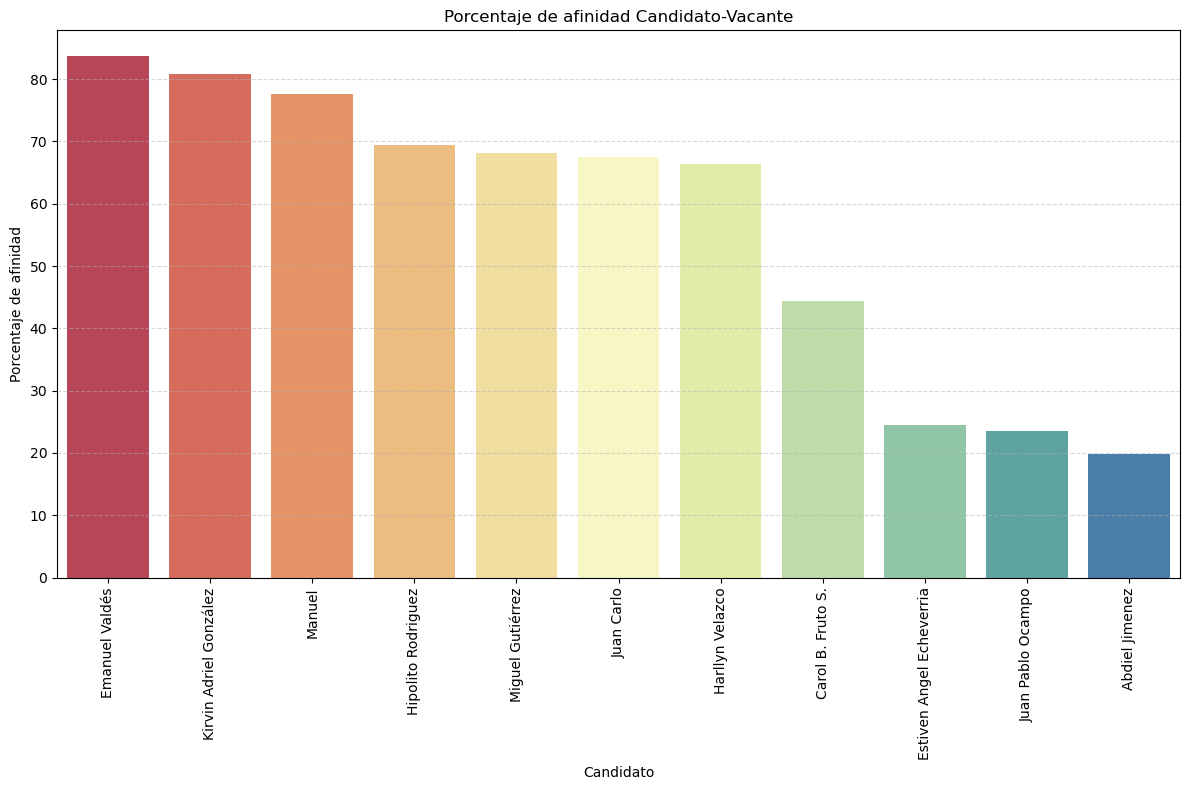

In [73]:
# Graficar los resultados de los porcentajes:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='Candidato', y='Porcentaje de afinidad', data=combinedScoresDF, hue='Candidato', palette='Spectral',ax=ax)
plt.title("Porcentaje de afinidad Candidato-Vacante")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

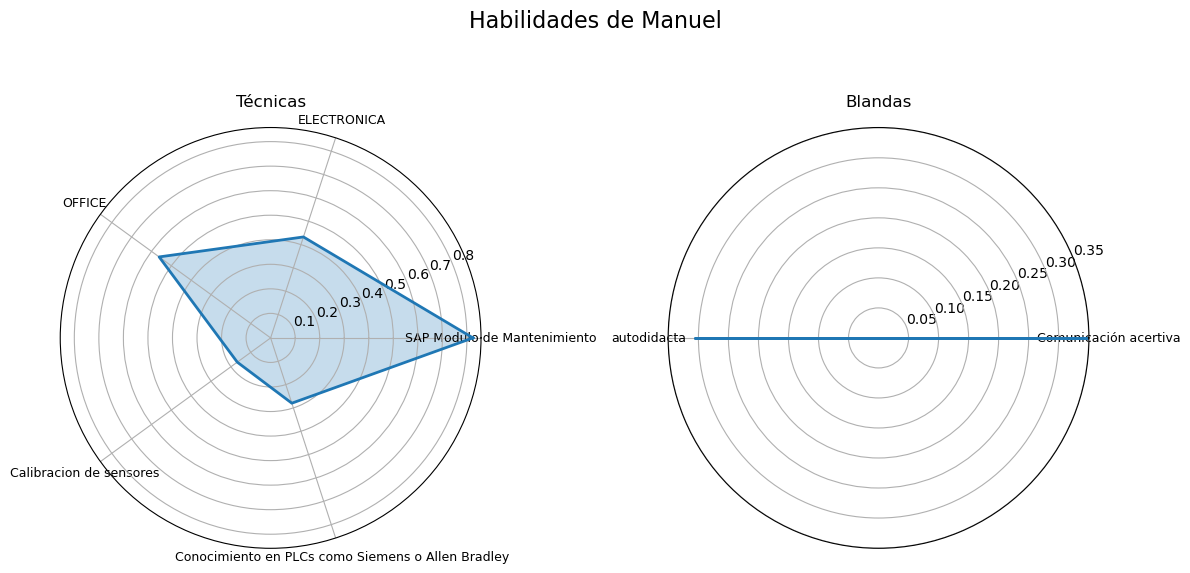

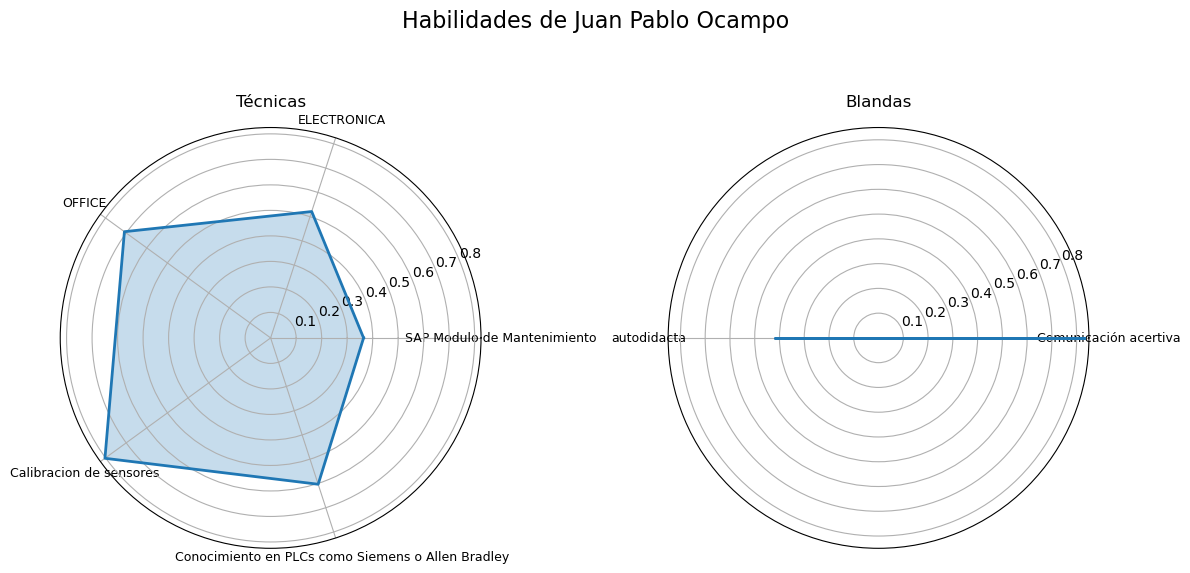

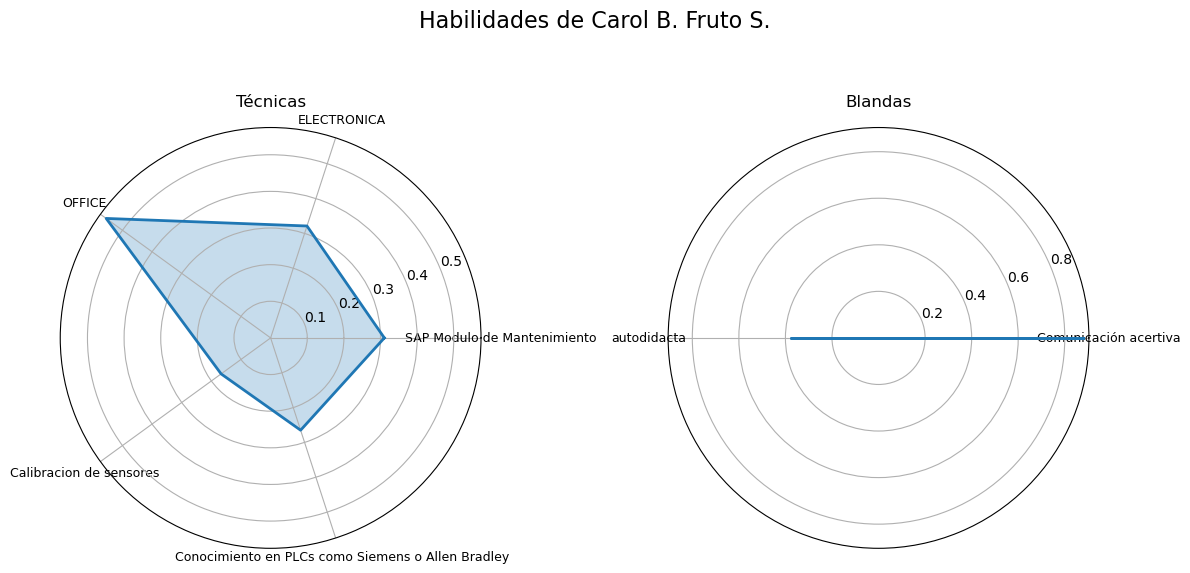

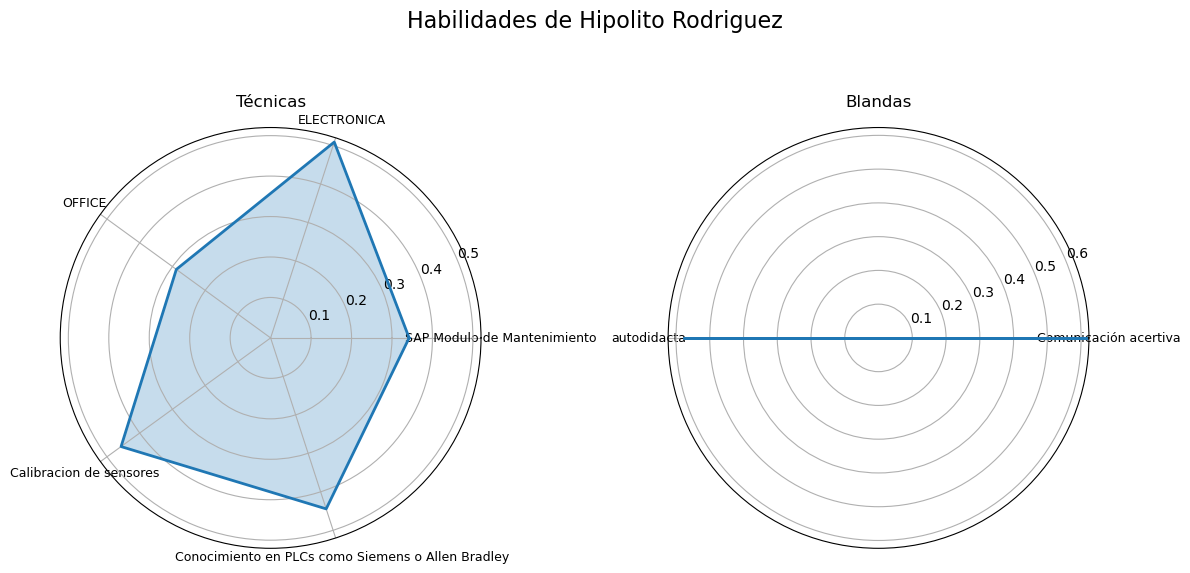

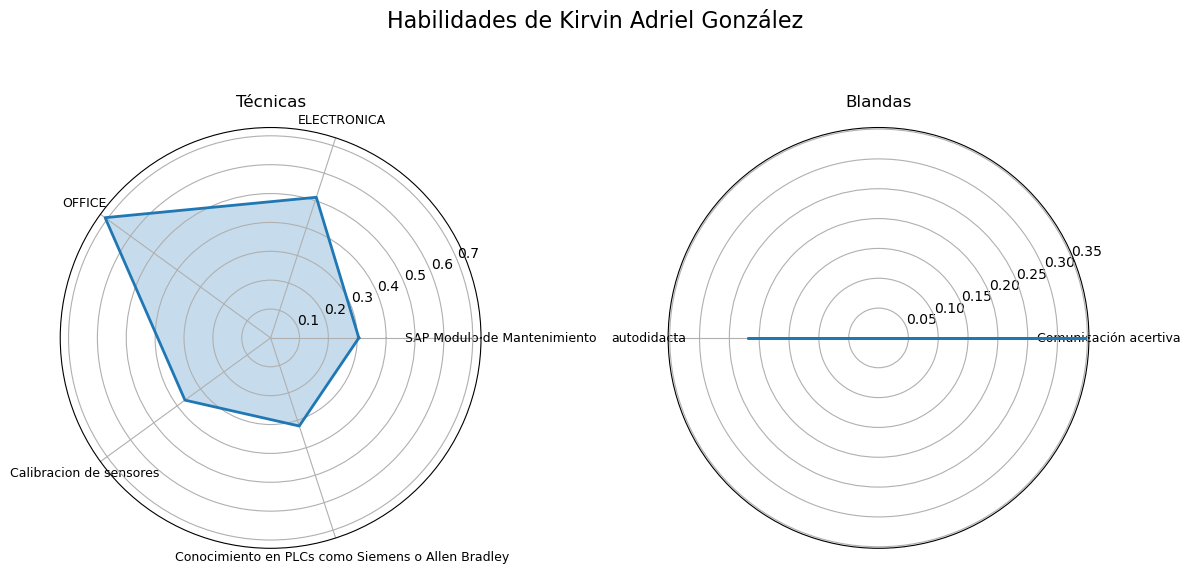

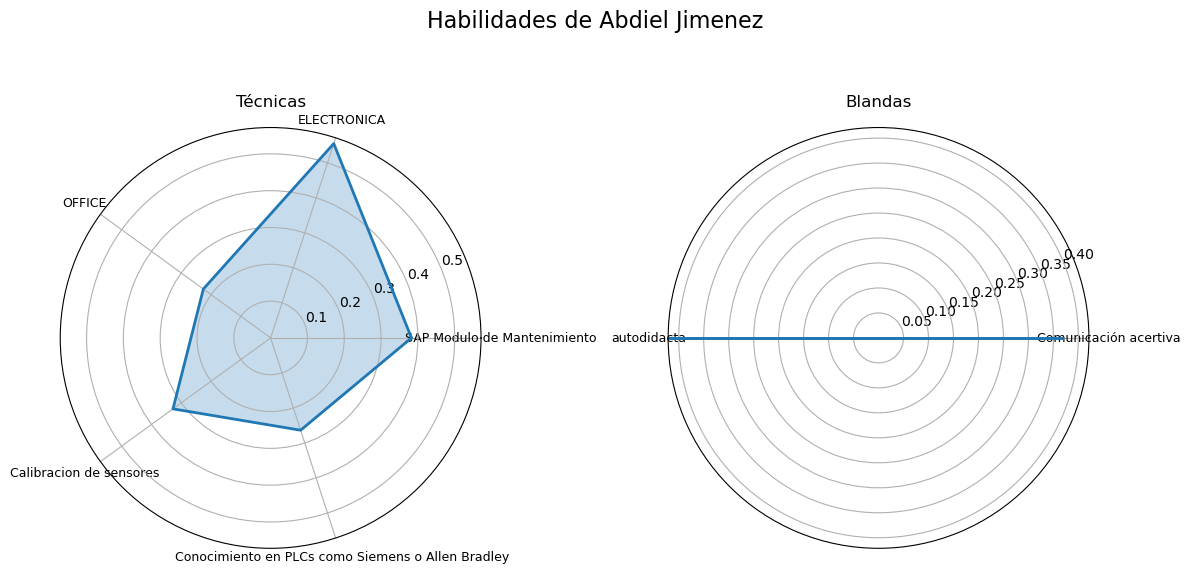

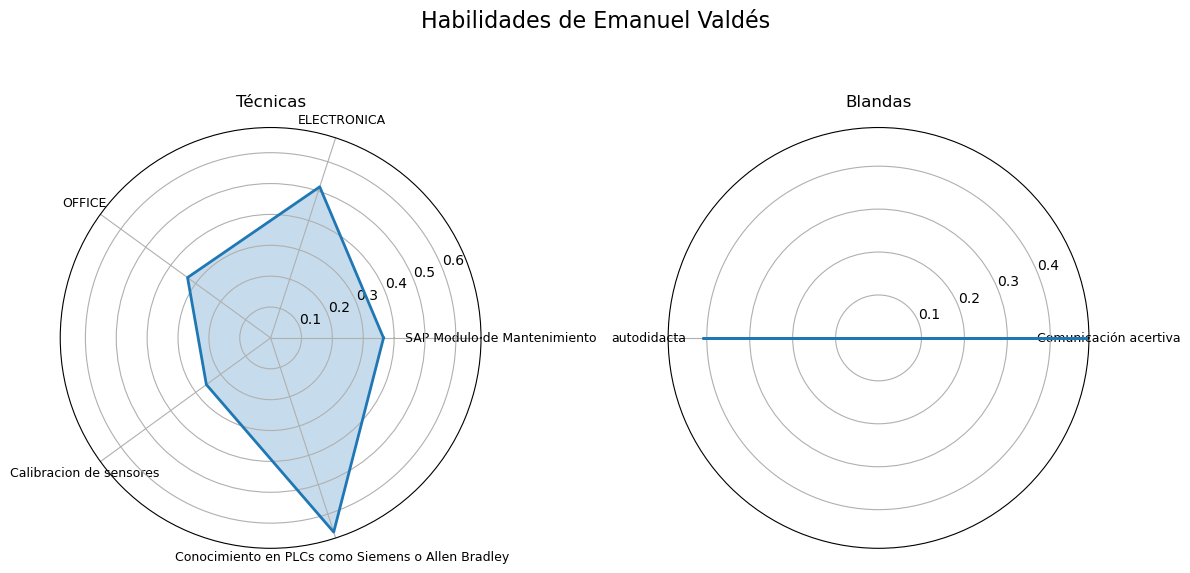

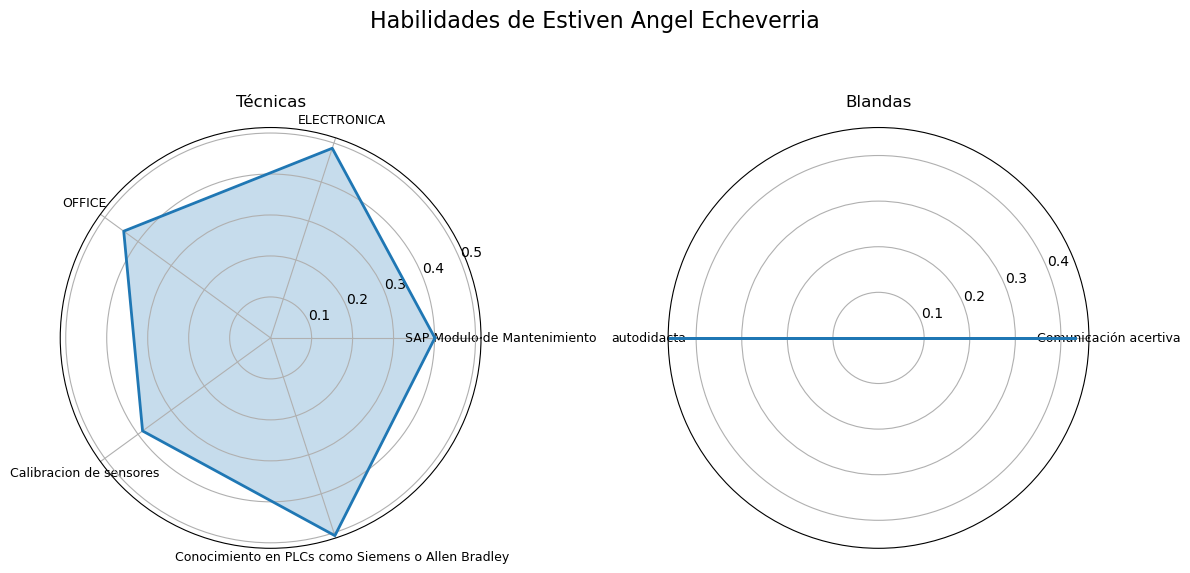

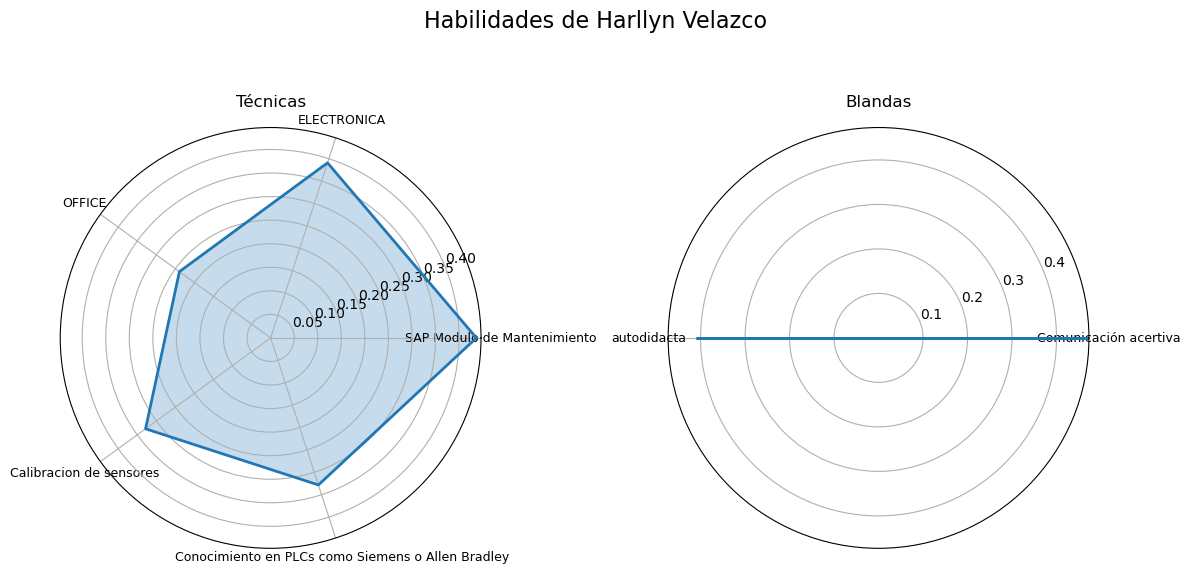

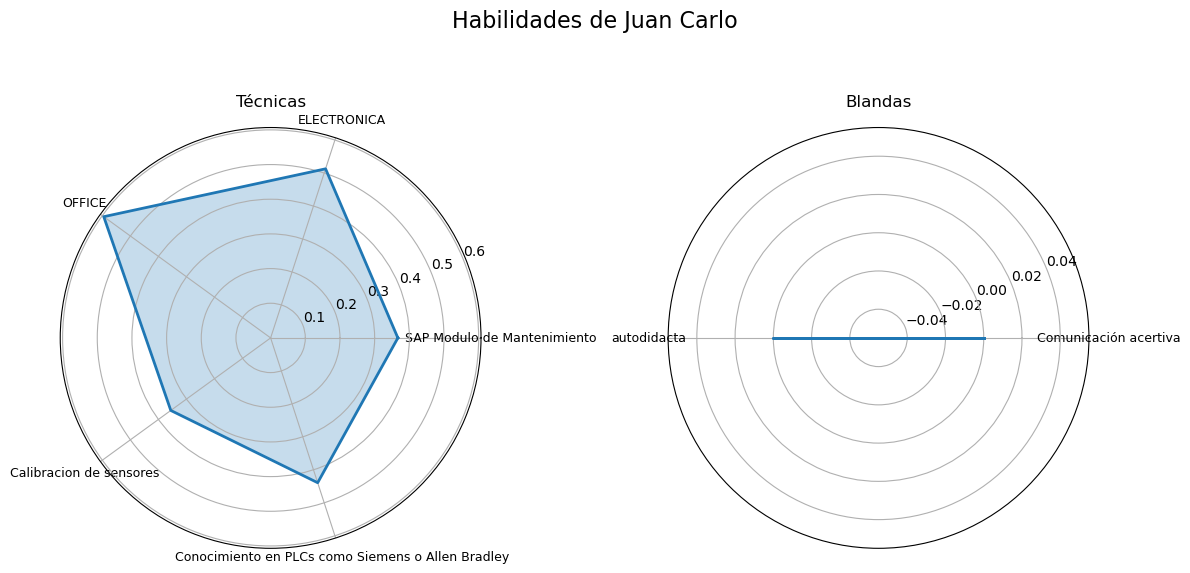

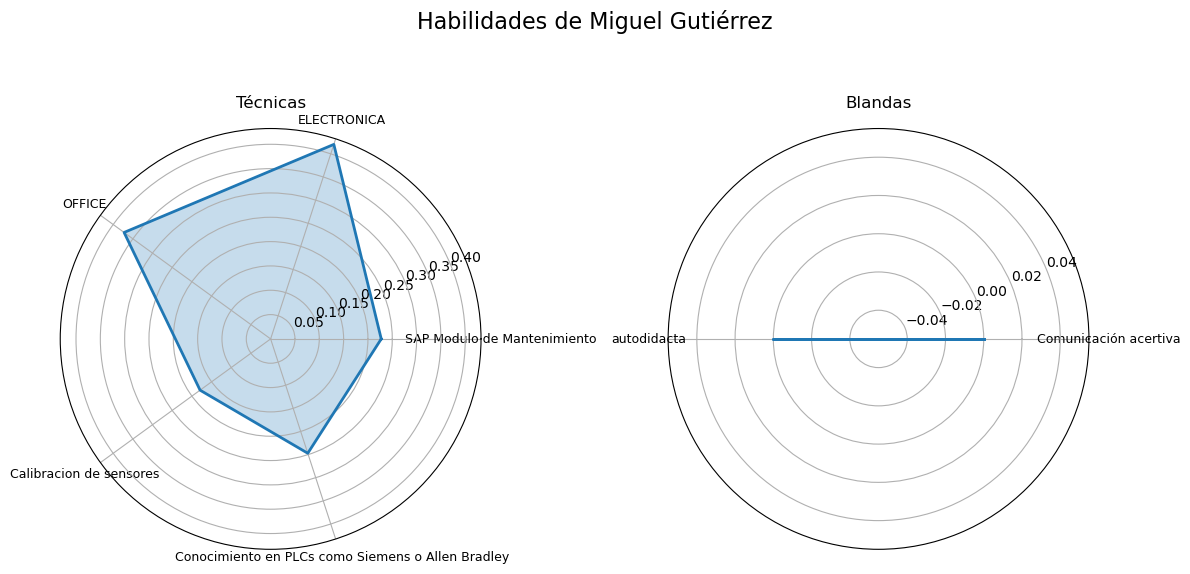

In [74]:
radarSkills(scoresPerSkill, jobInfo, mode="individual") # Graficar las habilidades de cada candidato

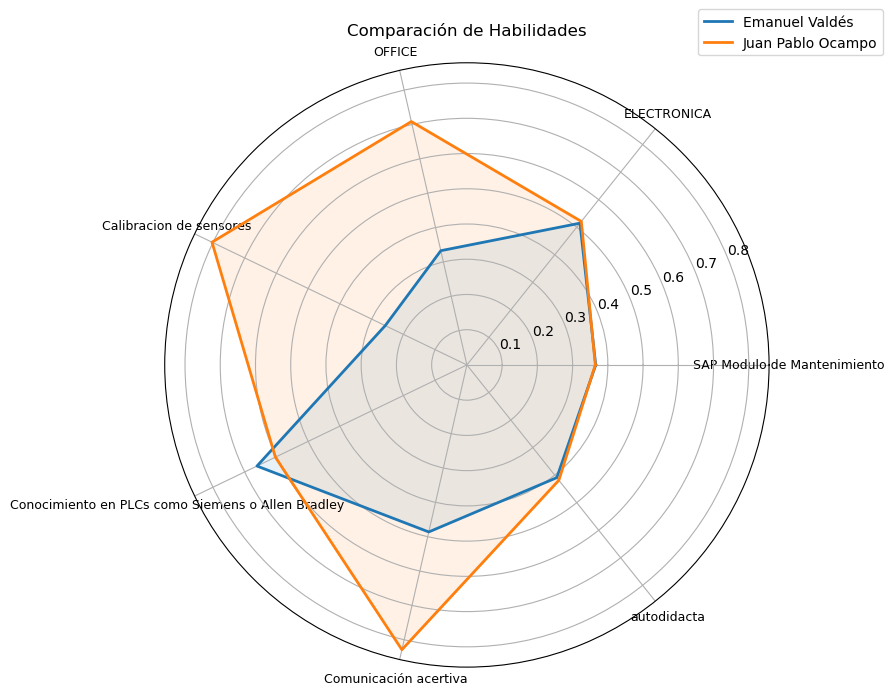

In [77]:
candidate1 = "Emanuel Valdés"
candidate2 = "Juan Pablo Ocampo"
radarSkills(scoresPerSkill, jobInfo, candidatos=[candidate1, candidate2], mode="compare")